In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import requests


c:\Users\sonor\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[ 1.76607776e+03]
 [-1.76019485e+03]
 [-2.45376994e+01]
 ...
 [-1.83431965e+03]
 [-2.22578294e+04]
 [-4.01248949e+04]]


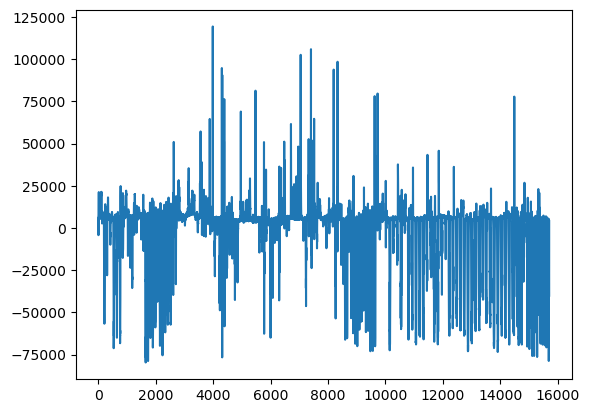

In [2]:
training_set_df = pd.read_csv("power_usage.csv")

training_set = training_set_df.iloc[:, 2:3].values
print(training_set)
training_set = [i for i in training_set if float(i) > -100000]
plt.plot(training_set)
plt.show()

In [3]:
# How many hours? 6? So 6 hours is 36
seq_length = 36

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [4]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length=5):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to("cuda")
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to("cuda")

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out


In [5]:
# num_epochs = 2000
# learning_rate = 0.01

# input_size = 1
# hidden_size = 2
# num_layers = 1
# num_classes = 1

# lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [6]:
# criterion = torch.nn.MSELoss()    
# optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# early_stop = 50
# least_loss = np.inf
# # Train the model
# for epoch in range(num_epochs):
#     outputs = lstm(trainX)
#     optimizer.zero_grad()
    
#     # obtain the loss function
#     loss = criterion(outputs, trainY)
#     loss.backward()
#     optimizer.step()

#     if least_loss > loss.item():
#        least_loss = loss.item()
#        early_stop = 50
#     else:
#        early_stop -= 1
    
#     if epoch % 100 == 0:
#       print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
#     if early_stop <= 0:
#       print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))


In [7]:
# lstm.eval()
# train_predict = lstm(dataX)

# data_predict = train_predict.data.numpy()
# dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

# #Plot the Predictions
# plt.axvline(x=train_size, c='r', linestyle='--')

# plt.plot(dataY_plot, label="True")
# plt.plot(data_predict, label="Predicted")
# plt.legend()
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [8]:
# '''
# Implement MSE calculation for the test data
# '''
# lstm.eval()
# test_predictions = lstm(testX)
# test_loss = criterion(test_predictions, testY)


# print(f"Test Loss for model trained 2000 epochs: {test_loss.item()}")


In [9]:
# # Get the last 37 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
# response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=4320")
# usage = response.json()
# ten_minute_averages = {"timestamp": [], "power": []}

# for i in range(0, len(usage['data']), 85):
#     values = usage['data'][i:i+120]
#     power = [value['power'] for value in values]
#     ten_minute_averages["timestamp"].append(values[0]['timestamp'])
#     ten_minute_averages["power"].append(np.average(power) * 1000)

# power = ten_minute_averages["power"]
# power = [[i] for i in power]
# power = np.array(power)

In [10]:
# power = sc.fit_transform(power)
# testNewX, testNewY = sliding_windows(power, seq_length)
# testDataX = Variable(torch.Tensor(np.array(testNewX[0:len(testNewX)])))
# testDataY = Variable(torch.Tensor(np.array(testNewY[0:len(testNewY)])))

# lstm.eval()
# test_predict = lstm(testDataX)

# data_predict = test_predict.data.numpy()
# dataY_test_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(testDataY)

# #Plot the Predictions
# plt.axvline(x=0, c='r', linestyle='--')

# plt.plot(dataY_plot, label="True")
# plt.plot(data_predict, label="Predicted")
# plt.legend()
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [11]:
# # How many hours? 6? So 6 hours is 36
# seq_length = 36

# def sliding_windows(data, seq_length):
#     x = []
#     y = []

#     for i in range(len(data) - seq_length - 1):
#         _x = data[i:(i+seq_length)]
#         _y = data[i+seq_length]
#         x.append(_x)
#         y.append(_y)

#     return np.array(x), np.array(y)

# sc = MinMaxScaler()
# training_data = sc.fit_transform(training_set)

# x, y = sliding_windows(training_data, seq_length)

# train_size = int(len(y) * 0.67)
# test_size = len(y) - train_size

# dataX = Variable(torch.Tensor(np.array(x)))
# dataY = Variable(torch.Tensor(np.array(y)))

# trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
# trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
# testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [12]:
# num_epochs = 5000
# learning_rate = 0.01

# input_size = 1
# hidden_size = 2
# num_layers = 1
# num_classes = 1

# lstm_5000 = LSTM(num_classes, input_size, hidden_size, num_layers)

In [13]:
# criterion = torch.nn.MSELoss()    
# optimizer = torch.optim.Adam(lstm_5000.parameters(), lr=learning_rate)
# early_stop = 50
# least_loss = np.inf
# # Train the model
# for epoch in range(num_epochs):
#     outputs = lstm_5000(trainX)
#     optimizer.zero_grad()
    
#     # obtain the loss function
#     loss = criterion(outputs, trainY)
#     loss.backward()
#     optimizer.step()

#     if least_loss > round(loss.item(), 7):
#       #  print("Better!")
#       #  print(loss.item())
#       #  print(least_loss)
#        least_loss = round(loss.item(), 7)
#        early_stop = 50
#     else:
#        early_stop -= 1
    
#     if epoch % 100 == 0:
#       print("Epoch: %d, loss: %1.5f, early stop: %d" % (epoch, loss.item(), early_stop))
    
#     if early_stop <= 0:
#       print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))
#       break


In [14]:
# lstm_5000.eval()
# train_predict = lstm_5000(dataX)

# data_predict = train_predict.data.numpy()
# dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

# #Plot the Predictions
# plt.axvline(x=train_size, c='r', linestyle='--')

# plt.plot(dataY_plot, label="True")
# plt.plot(data_predict, label="Predicted")
# plt.legend()
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [15]:
# '''
# Implement MSE calculation for the test data
# '''
# lstm_5000.eval()
# test_predictions = lstm_5000(testX)
# test_loss = criterion(test_predictions, testY)


# print(f"Test Loss for model trained 2000 epochs: {test_loss.item()}")

In [16]:
# # Get the last 37 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
# response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=4320")
# usage = response.json()
# ten_minute_averages = {"timestamp": [], "power": []}

# for i in range(0, len(usage['data']), 85):
#     values = usage['data'][i:i+120]
#     power = [value['power'] for value in values]
#     ten_minute_averages["timestamp"].append(values[0]['timestamp'])
#     ten_minute_averages["power"].append(np.average(power) * 1000)

# power = ten_minute_averages["power"]
# power = [[i] for i in power]
# power = np.array(power)

# power = sc.fit_transform(power)
# testNewX, testNewY = sliding_windows(power, seq_length)
# testDataX = Variable(torch.Tensor(np.array(testNewX[0:len(testNewX)])))
# testDataY = Variable(torch.Tensor(np.array(testNewY[0:len(testNewY)])))

# lstm_5000.eval()
# test_predict = lstm_5000(testDataX)

# data_predict = test_predict.data.numpy()
# dataY_test_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(testDataY)

# #Plot the Predictions
# plt.axvline(x=0, c='r', linestyle='--')

# plt.plot(dataY_plot, label="True")
# plt.plot(data_predict, label="Predicted")
# plt.legend()
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [17]:
# num_epochs = 5000
# learning_rates = [0.01, 0.001, 0.0001, 0.00001]
# learning_rate = 0.01

# input_size = 1
# # hidden_size = 2
# num_layers = 1
# num_classes = 1

# seq_lengths = [36, 42, 50, 68, 75, 144] # We did 5 previously
# hidden_sizes = [3, 7, 12, 32, 64] # We did 2 previously
# # fig, ax = plt.subplots(6, 5, figsize=(30, 30))
# device = "cuda"
# best_seq = 0
# best_hidden_size = 0
# best_lr = 0
# lowest_loss = np.inf
# for lr in learning_rates:
#     for i, seq_length in enumerate(seq_lengths):
#         for j, hidden_size in enumerate(hidden_sizes):
#             print(f"Starting with a sequence length of {seq_length} and hidden_size of {hidden_size}")
#             lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
#             lstm = lstm.to(device)
#             early_stop = 10
#             least_loss = np.inf
#             criterion = torch.nn.MSELoss()    
#             optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

#             # Train the model
#             for epoch in range(num_epochs):
#                 trainX = trainX.to(device)
#                 trainY = trainY.to(device)
#                 outputs = lstm(trainX)
#                 optimizer.zero_grad()
                
#                 # obtain the loss function
#                 loss = criterion(outputs, trainY)
#                 loss.backward()
#                 optimizer.step()
                
#                 if least_loss > loss.item():
#                     least_loss = loss.item()
#                     early_stop = 10
#                 else:
#                     early_stop -= 1

#                 if epoch % 100 == 0:
#                     print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
                
#                 if early_stop <= 0:
#                     print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))
#                     break

#             lstm.eval()
#             dataX = dataX.to(device)
#             dataY = dataY.to(device)
#             train_predict = lstm(dataX)

#             data_predict = train_predict.cpu().data.numpy()
#             dataY_plot = dataY.cpu().data.numpy()

#             data_predict = sc.inverse_transform(data_predict)
#             dataY_plot = sc.inverse_transform(dataY_plot)

#             lstm.eval()
#             testX = testX.to(device)
#             testY = testY.to(device)
#             test_predictions = lstm(testX)
#             test_loss = criterion(test_predictions, testY)

#             if test_loss.item() < lowest_loss:
#                 lowest_loss = test_loss
#                 best_seq = seq_length
#                 best_hidden_size = hidden_size
#                 best_lr = lr
#             #Plot the Predictions
#             # ax[i][j].axvline(x=train_size, c='r', linestyle='--')
#             # ax[i][j].set_title(f"Loss: {round(test_loss.item(), 5)}, Seq_Length: {seq_length}, Hidden_Size: {hidden_size}")

#             # ax[i][j].plot(dataY_plot)
#             # ax[i][j].plot(data_predict)


# # plt.suptitle('Time-Series Prediction')
# # plt.show()
# print(f"Best Loss: {lowest_loss} on sequence length {seq_length}, hidden size of {hidden_size} and learning rate of {best_lr}")

In [24]:
# How many hours? 6? So 6 hours is 36
seq_length = 144
device = "cuda"
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
trainX = trainX.to(device)
trainY = trainY.to(device)
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))

num_epochs = 5000
learning_rate = 0.001

input_size = 1
hidden_size = 64
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm = lstm.to(device)


In [25]:
criterion = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
early_stop = 10
least_loss = np.inf
# Train the model
for epoch in range(num_epochs):

   outputs = lstm(trainX)
   optimizer.zero_grad()
   
   # obtain the loss function
   loss = criterion(outputs, trainY)
   loss.backward()
   optimizer.step()

   if least_loss > loss.item():
      least_loss = loss.item()
      early_stop = 10
   else:
      early_stop -= 1
   
   if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
   
   if early_stop <= 0:
      print("Epoch: %d, loss: %1.5f, best_loss: %1.5f" % (epoch, loss.item(), least_loss))


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.18 GiB (GPU 0; 8.00 GiB total capacity; 416.02 MiB already allocated; 6.17 GiB free; 778.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

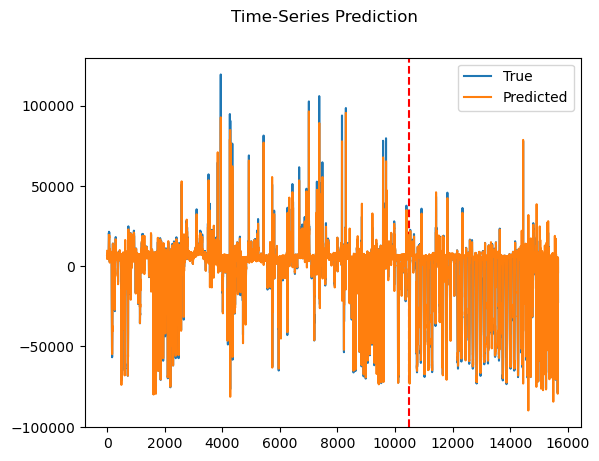

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

#Plot the Predictions
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
'''
Implement MSE calculation for the test data
'''
lstm.eval()
test_predictions = lstm(testX)
test_loss = criterion(test_predictions, testY)


print(f"Test Loss for model trained 2000 epochs: {test_loss.item()}")

c:\Users\sonor\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([5171, 1])) that is different to the input size (torch.Size([5169, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (5169) must match the size of tensor b (5171) at non-singleton dimension 0

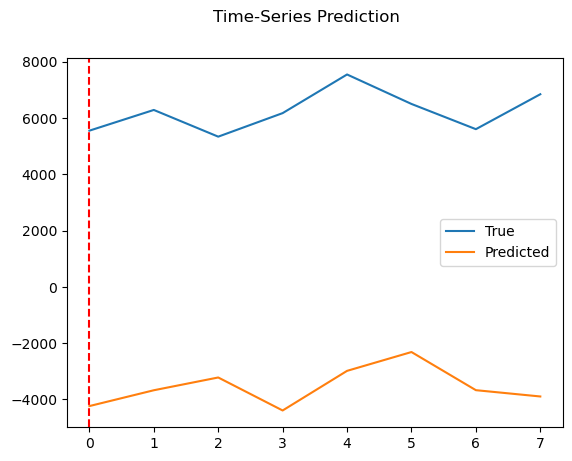

In [ ]:
# Get the last 37 points of 10 minute chunks (so if every 5 seconds, that is 4320) and predict what the prices will be
response = requests.get(f"http://144.39.204.242:11236/evr/leviton/evr?limit=4320")
usage = response.json()
ten_minute_averages = {"timestamp": [], "power": []}

for i in range(0, len(usage['data']), 85):
    values = usage['data'][i:i+120]
    power = [value['power'] for value in values]
    ten_minute_averages["timestamp"].append(values[0]['timestamp'])
    ten_minute_averages["power"].append(np.average(power) * 1000)

power = ten_minute_averages["power"]
power = [[i] for i in power]
power = np.array(power)

power = sc.fit_transform(power)
testNewX, testNewY = sliding_windows(power, seq_length)
testDataX = Variable(torch.Tensor(np.array(testNewX[0:len(testNewX)])))
testDataY = Variable(torch.Tensor(np.array(testNewY[0:len(testNewY)])))

lstm.eval()
test_predict = lstm(testDataX)

data_predict = test_predict.data.numpy()
dataY_test_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testDataY)

#Plot the Predictions
plt.axvline(x=0, c='r', linestyle='--')

plt.plot(dataY_plot, label="True")
plt.plot(data_predict, label="Predicted")
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()